In [1]:
import numpy as np
import pandas as pd
import datetime
from astral.sun import sun
from astral import LocationInfo
import os

# Generate timestamps for instances with 5-minute intervals throughout the year
start_time = datetime.datetime(2022, 1, 1, 0, 0)
end_time = datetime.datetime(2022, 12, 31, 23, 59)
total_minutes = int((end_time - start_time).total_seconds() / 60)
# Set the interval to 5 minutes
minute_interval = 5

# Calculate the total number of instances
num_instances = total_minutes // minute_interval

# This line creates a list of timestamps that start from start_time
timestamps = [start_time + datetime.timedelta(minutes=minute_interval * i) for i in range(num_instances)]

# Set the location for sunrise and sunset calculations
location = LocationInfo("St. Gallen", "Switzerland")
location.latitude = 47.4245
location.longitude = 9.3767

# This function generates the brightness based on the time of day
def generate_brightness(time):
    s = sun(location.observer, date=time.date())
    sunrise_hour = (s["sunrise"] - s["sunrise"].replace(hour=0, minute=0)).seconds / 3600
    sunset_hour = (s["sunset"] - s["sunset"].replace(hour=0, minute=0)).seconds / 3600
    current_hour = time.hour + time.minute / 60

    # Set brightness based on current hour within sunrise period
    if sunrise_hour <= current_hour < (sunrise_hour + 6):
        # If current hour is between 6 hours before sunset and sunset set brightness from 100 to 0
        return np.interp(current_hour, [sunrise_hour, sunrise_hour + 6], [0, 100])
    elif (sunset_hour - 6) <= current_hour < sunset_hour:
        # If current hour is between 6 hours before sunset and sunset set brightness from 100 to 0
        return np.interp(current_hour, [sunset_hour - 6, sunset_hour], [100, 0])
    # If current hour is between 6 hours after sunrise and 6 hours before sunset set brightness to 100
    elif (sunrise_hour + 6) <= current_hour < (sunset_hour - 6):
        return 100
    # For all other times set brightness to 0
    else:
        return 0

# Generate the brightness data
brightness_data = [generate_brightness(t) for t in timestamps]

# Add noise to the brightness values
noise = np.random.normal(0, 5, len(brightness_data))
brightness_data = brightness_data + noise
brightness_data = np.clip(brightness_data, 0, 100)

# Store the data in a Pandas DataFrame
sensor_data = pd.DataFrame({
    'ts': timestamps,
    'br': brightness_data
})

# Save the data to a CSV file
sensor_data.to_csv(os.path.expanduser("~/Desktop/brightness_sensor_data_full_year.csv"), index=False)

In [7]:
import numpy as np
import pandas as pd
import datetime
import os

# Generate timestamps for instances with 5-minute intervals throughout the year
start_time = datetime.datetime(2022, 1, 1, 0, 0)
end_time = datetime.datetime(2022, 12, 31, 23, 59)
total_minutes = int((end_time - start_time).total_seconds() / 60)
# Set the interval to 5 minutes
minute_interval = 5

# Calculate the total number of instances
num_instances = total_minutes // minute_interval

# This line creates a list of timestamps that start from start_time
timestamps = [start_time + datetime.timedelta(minutes=minute_interval * i) for i in range(num_instances)]

# Define a function for seasonality
def seasonality_factor(time):
    # Convert the date to the day of the year
    day_of_year = time.timetuple().tm_yday
    # Calculate the seasonality factor using a cosine function that oscillates between 0 and 1 throughout the year
    # https://stats.stackexchange.com/questions/549152/can-you-suggest-a-novice-method-for-detrending-and-deseasoning-time-series-to-fi
    # https://stackoverflow.com/questions/72722387/generate-time-series-for-day-year-fluctuations-using-python
    return 0.5 * (1 + np.cos((day_of_year - 172) / 365 * 2 * np.pi))

# Define a function for daily temperature variation using a cosine function peak at 14:00 and bottom at 02:00 (please see plot below)
def daily_temperature_variation(time, min_temp, max_temp):
    current_hour = time.hour + time.minute / 60
    return min_temp + (max_temp - min_temp) * (1 + np.cos(2 * np.pi * (current_hour - 14) / 24)) / 2

# Specify max and min temperatures for each season
def generate_temperature(time):
    winter_min_temp = -5
    winter_max_temp = 5
    summer_min_temp = 15
    summer_max_temp = 25

    # With the seasonality specified above the maximum and minimum temperatures are set
    min_temp = winter_min_temp + (summer_min_temp - winter_min_temp) * seasonality_factor(time)
    max_temp = winter_max_temp + (summer_max_temp - winter_max_temp) * seasonality_factor(time)

    # Insert into the daily temperature variation function above
    return daily_temperature_variation(time, min_temp, max_temp)

# Generate the temperature data
temperature_data = [generate_temperature(t) for t in timestamps]

# Add noise to the temperature values
temperature_noise = np.random.normal(0, 1, len(temperature_data))
temperature_data = temperature_data + temperature_noise
temperature_data = np.clip(temperature_data, -5, 25)

# Store the data in a Pandas DataFrame
sensor_data = pd.DataFrame({
    'ts': timestamps,
    'temp': temperature_data
})

# Save the data to a CSV file
sensor_data.to_csv(os.path.expanduser("~/Desktop/temperature_sensor_data_full_year.csv"), index=False)

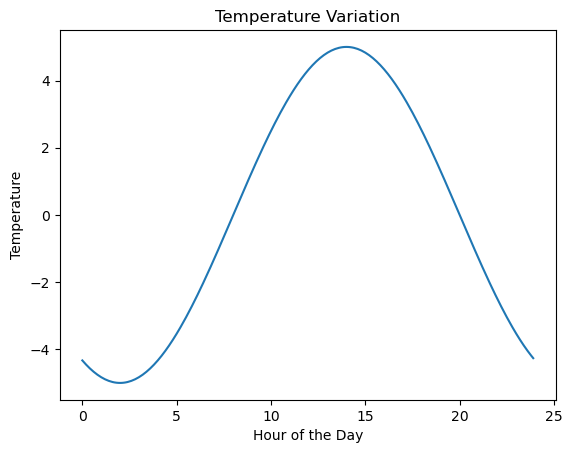

In [8]:
import numpy as np
import matplotlib.pyplot as plt

min_temp = -5
max_temp = 5
hours = np.arange(0, 24, 0.1)
# 14:00 is specified as the peak where 12 hours later the bottom is reached at 02:00
temperature = min_temp + (max_temp - min_temp) * (1 + np.cos(2 * np.pi * (hours - 14) / 24)) / 2

plt.plot(hours, temperature)
plt.xlabel('Hour of the Day')
plt.ylabel('Temperature')
plt.title('Temperature Variation')
plt.show()